In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import torch
import random
import math 
import copy
import random
import argparse
import torch.optim as optim
import torch.nn as nn
import modeldefine
import numpy as np
from scipy.optimize import minimize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
alpha = 0.01

def UCB(A, phi):
    #### ucb term
    phi = phi.view(-1,1)
    try:
        tmp, LU = torch.linalg.solve(phi,A)
    except:
        A = A.detach().numpy()
        phi2 = phi.detach().numpy()
        tmp = torch.Tensor(np.linalg.solve(A, phi2))

    return torch.sqrt(torch.matmul(torch.transpose(phi,1,0), tmp))

def calculate_v(contextinfo_list, A, theta):
    vj_list = []
    feature_list = []
    for i in contextinfo_list:
        feature = model(i.to(device)).cpu()
        first_item =  torch.mm( feature.view(1,-1) , theta)
        second_item = alpha * UCB(A, feature)
        vj_list.append((first_item + second_item).item())
        feature_list.append(feature.detach().numpy())
    return np.array(vj_list), feature_list

def update_A(A, info_subset):
    for i in info_subset:
        i = torch.tensor(i, dtype=torch.float32,device=device)
        feature = model(i.to(device)).view(1,-1).cpu()
        A = A + torch.mm(feature.t(), feature)
    return A

# 这里调小utility 
def prob(vj_list):
    sum = np.sum(np.exp(vj_list)) + 1
    return [np.exp(vj_list[i]) / sum for i in range(len(vj_list))]  

def revenue(vj_list, reward_list):
    sum = np.sum(np.exp(vj_list)) + 1
    return np.sum(np.multiply(np.exp(vj_list), reward_list) / sum)

def assort(contextinfo_list, reward_list, vj_list, feature_list):
    length = len(vj_list)
    # sort the contextinfo_list and vj with descending order of reward_list
    sorted_list = sorted(zip(contextinfo_list, vj_list, reward_list, feature_list), key=lambda x: x[2], reverse=True)
    
    contextinfo_list = [x[0] for x in sorted_list]
    vj_list = [x[1] for x in sorted_list]
    reward_list = [x[2] for x in sorted_list]
    feature_list = [x[3] for x in sorted_list]

    # calculate the optimal assortment
    optimal_assort = []
    optimal_reward = 0
    index = 1
    for i in range(length):
        if revenue(vj_list[:index], reward_list[:index]) >= optimal_reward:
            optimal_reward = revenue(vj_list[:index], reward_list[:index])
            index += 1
        else:
            break
    return contextinfo_list[:index], feature_list[:index], vj_list[:index], reward_list[:index]

# this is for the linear purchase model when v = x dot theta
def get_linear_purchase(feature_list):
    true_Vlist = [(TRUE_THETA @ feature_list[i].reshape(-1,1)).item() for  i in range(len(feature_list))]
    prob_list = prob(true_Vlist)

    # sample item according to prob_list
    if random.uniform(0,1) < 1 - np.sum(prob_list):
        return np.array([0 for i in range(len(feature_list))])
    else:
        returnlist = [0 for i in range(len(feature_list))]
        indexchoose = random.choices([i for i in range(len(prob_list))], weights = prob_list)[0]
        returnlist[indexchoose] = 1
        return np.array(returnlist)

In [3]:
lambd = 1
def likelihood(theta, feature_list ,y_list):
    # feature's dimension is len * dimension , theta is 1*dimension
    v_list = np.matmul(feature_list, theta.T).reshape(-1)
    ln_prob = np.log(prob(v_list))
    summation = ln_prob * y_list
    return -1 * np.sum(summation)

def likelihood_derivative(theta, feature_list, y_list):
    v_list = np.matmul(feature_list, theta.T).reshape(-1)
    prob_list = prob(v_list)
    summation = np.matmul(np.array(feature_list).T, (y_list - prob_list))
    return -1 * summation

def likelihood_array(theta, feature_list_list, y_list_list):
    summation =  0.5 * lambd * np.dot(theta, theta)
    for i in range(len(feature_list_list)):
        summation += likelihood(theta, feature_list_list[i], y_list_list[i])
    return summation

def likelihood_derivative_array(theta, feature_list_list, y_list_list):
    summation = 0.5 * lambd * theta
    for i in range(len(feature_list_list)):
        summation += likelihood_derivative(theta, feature_list_list[i], y_list_list[i])
    return summation

In [4]:
class CustomLikelihoodLoss(nn.Module): 
    def __init__(self, theta_list):
        super(CustomLikelihoodLoss, self).__init__()
        self.theta_list = theta_list

    def forward(self, output_list, y_list):
        loss = 0
        index = 0
        for output in output_list:  
            y = torch.tensor(y_list[index]).to(device) .view(-1,1)
            theta = torch.tensor(self.theta_list[index], dtype= torch.float32).to(device) 
            v = torch.mm(output, theta.view(-1,1)) 
            prob = torch.exp(v) / (torch.sum(torch.exp(v)) + 1)  
            loss += torch.sum(torch.log(prob) * y)  
            index += 1  
        return -loss 

class CustomLikelihoodLoss2(nn.Module):
    def __init__(self, theta_list):
        super(CustomLikelihoodLoss2, self).__init__()
        self.theta_list = theta_list
     
    def forward(self, output_list, y_list):
        loss = 0
        index = 0
        for output in output_list:
            y = torch.tensor(y_list[index]).to(device).view(-1,1)
            theta = torch.tensor(self.theta_list[index], dtype= torch.float32).to(device)
            v = torch.mm(output, theta.view(-1,1))
            prob = torch.exp(v) / (torch.sum(torch.exp(v)) + 1)
            # ce loss between prob and y
            loss += torch.sum(-y * torch.log(prob) - (1-y) * torch.log(1-prob))
            index += 1
        return loss 


In [5]:
# this block is only used for linear model revenue calculation
def calculate_linear_v(contextinfo_list, A, theta):
    vj_list = []
    feature_list = []
    for i in contextinfo_list:
        feature = i
        first_item =  torch.mm( feature.view(1,-1) , theta)
        second_item = alpha * UCB(A, feature)
        vj_list.append((first_item + second_item).item())
        feature_list.append(feature.detach().numpy())
    return np.array(vj_list), feature_list

# 真实情况乱下的theta，feature
def get_true_linear_ass(context, profit):
    theta_tensor = torch.tensor(TRUE_THETA.reshape(-1,1), dtype=torch.float32)
    v_array,initial_feature = calculate_linear_v(torch.tensor(context,dtype=torch.float32), LAMBDA, theta_tensor)
    assortment, ass_features, v_list, profit_list = assort(context, profit.tolist()[0], v_array.tolist() , initial_feature)
    true_probablility = np.array(prob(v_list))
    revenue = np.dot(true_probablility, np.array(profit_list))
    return revenue

# 真实情况下的theta 和 神经网络输出的 feature
def get_linear_ass(context, profit):
    theta_tensor = torch.tensor(TRUE_THETA.reshape(-1,1), dtype=torch.float32)
    v_array,initial_feature = calculate_v(torch.tensor(context,dtype=torch.float32), LAMBDA, theta_tensor)
    assortment, ass_features, v_list, profit_list = assort(context, profit.tolist()[0], v_array.tolist() , initial_feature)
    probability = np.array(prob(v_list))
    revenue = np.dot(probability, np.array(profit_list))
    return revenue

In [6]:
import modeldefine
import torch.optim as optim
model = modeldefine.Model(5,10,10,2).to(device)
# 10 20 20 20 20 20  5
optimizer = optim.SGD(model.parameters(), lr=0.001,weight_decay=0.01)

tensor([ 5, 10, 10, 10], dtype=torch.int32)


In [7]:
print(model)

Model(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [8]:
# data reader
CONTEXT_ARRAY = np.load('linear_data/features.npy') 
REWARD_ARRAY = np.load('linear_data/rewards.npy')
TRUE_THETA = np.load('linear_data/theta.npy')

In [11]:
data_length = len(CONTEXT_ARRAY)

# define the hyperparameters
input_size = 20
hidden_size = 20
output_size = 10
num_layers = 10

beta = 0.1

H = 100

# initialize the parameters

theta = np.random.randn(output_size) / np.sqrt(output_size)

LAMBDA = lambd * torch.eye(output_size, dtype=torch.float32)

ass_list = []
feature_list = []
purchase_list = []
theta_list = []

revenue_list1 = []
revenue_list2 = []
true_profit_list = []

for t in range(0,500):
    context = CONTEXT_ARRAY[t]
    profit = REWARD_ARRAY[t]

    theta_tensor = torch.tensor(theta.reshape(-1,1), dtype=torch.float32)
    v_array,initial_feature = calculate_v(torch.tensor(context,dtype=torch.float32), LAMBDA, theta_tensor)
    assortment, ass_features, _ , reward = assort(context, profit.tolist()[0], v_array.tolist() , initial_feature)
    purchase_vector = get_linear_purchase(assortment)
    
    # calculate the ideal 
    expected_revenue1 = get_true_linear_ass(context, profit)
    expected_revenue2 = get_linear_ass(context, profit)
    revenue_list1.append(expected_revenue1)
    revenue_list2.append(expected_revenue2)
    true_profit_list.append(np.dot(np.array(purchase_vector), reward))

    # add to list
    ass_list.append(np.array(assortment))
    feature_list.append(np.array(ass_features))
    purchase_list.append(purchase_vector)

    # update the parameters
    LAMBDA = update_A(LAMBDA, assortment)
    
    # update theta using MLE
    initial_guess = theta
    result = minimize(likelihood_array, initial_guess, args=(ass_list, purchase_list), method='SLSQP', 
                  constraints={'type':'eq', 'fun': likelihood_derivative_array, 'args':(ass_list, purchase_list)})
    theta = result.x
    theta_list.append(theta)

    # update the neural networks
    if t % H == 99:
        a_list = ass_list[-1*H:]
        y_list = purchase_list[-1*H:]

        loss_function = CustomLikelihoodLoss2(theta_list)
        epochs = 1
     
        for epoch in range(epochs):
            output_list = [model(torch.tensor(a,dtype = torch.float32).to(device)) for a in a_list]
            loss = loss_function(output_list, y_list)
            if (epoch == epochs-1): print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        theta_list = []

Epoch [1/1], Loss: 227.07933044433594
Epoch [1/1], Loss: 245.31884765625
Epoch [1/1], Loss: 238.46861267089844
Epoch [1/1], Loss: 227.56307983398438
Epoch [1/1], Loss: 221.63368225097656


In [12]:
revenue_list2

[7.988881095886617,
 8.19233450472235,
 8.267036481789113,
 8.471316959507094,
 6.361677288981918,
 8.10051906805844,
 7.554874987109507,
 8.313613954214528,
 8.187694241124841,
 8.247254652421958,
 8.490411307823425,
 8.152125797854973,
 7.325281734548324,
 6.520591420288131,
 8.712837811976403,
 8.082546792589728,
 8.242546522803728,
 8.71478185951016,
 7.7687190947512175,
 8.156286353626648,
 8.41386375156056,
 8.668543576878378,
 8.359579688010172,
 8.26562693515341,
 8.0591194095929,
 9.014628567979294,
 7.8427033478959265,
 8.556204291269559,
 8.175845365651858,
 7.833692876896344,
 8.370830471053557,
 7.960883271720161,
 7.909399307093437,
 8.453948255028635,
 8.671852947953003,
 8.146750035163755,
 8.719806276463832,
 8.205560234073769,
 7.176755095495608,
 7.625169015714332,
 7.581711725468048,
 8.135852880074893,
 8.547924693817507,
 8.769708533605913,
 8.310152069205122,
 7.4505361163445665,
 8.60684412512503,
 8.784546206630534,
 8.246582274995749,
 8.570085555755007,
 8.16

In [15]:
differ_list = [revenue_list1[i] - revenue_list2[i] for i in range(len(revenue_list1))]
differ_list

[0.7805155109126005,
 0.44989295704125354,
 0.9968534164011835,
 0.8226498587406521,
 1.0872616913169768,
 0.48872989119976396,
 0.38744300589064373,
 0.32010185769574484,
 1.1262937821399,
 0.7321407270104139,
 0.9953593680477901,
 0.8958039799306086,
 1.1691674038903903,
 0.8612594296292695,
 0.6196311186066623,
 0.9853686744457999,
 0.6654880813516364,
 0.7659613159206557,
 0.8036150694657866,
 1.0305192719307765,
 0.5964430510611631,
 0.42744722905528043,
 0.5595556339053864,
 0.9396197472302354,
 0.4623936766642043,
 0.5452692898430271,
 0.8338322140571099,
 0.5165310988915337,
 0.6870912307081483,
 0.6657221829459798,
 0.6494706766640235,
 1.3539916366362617,
 0.7624994607202744,
 0.6526479968398817,
 0.7779280511760192,
 0.6361538462158887,
 0.6925907039833668,
 0.7526749417342984,
 0.6800972660284383,
 0.8813821748603656,
 1.2605336218435825,
 0.544686632281401,
 0.7739767073441435,
 0.9096840762336509,
 0.6081980213973157,
 0.704156434689966,
 0.7963058340722462,
 0.6381836689

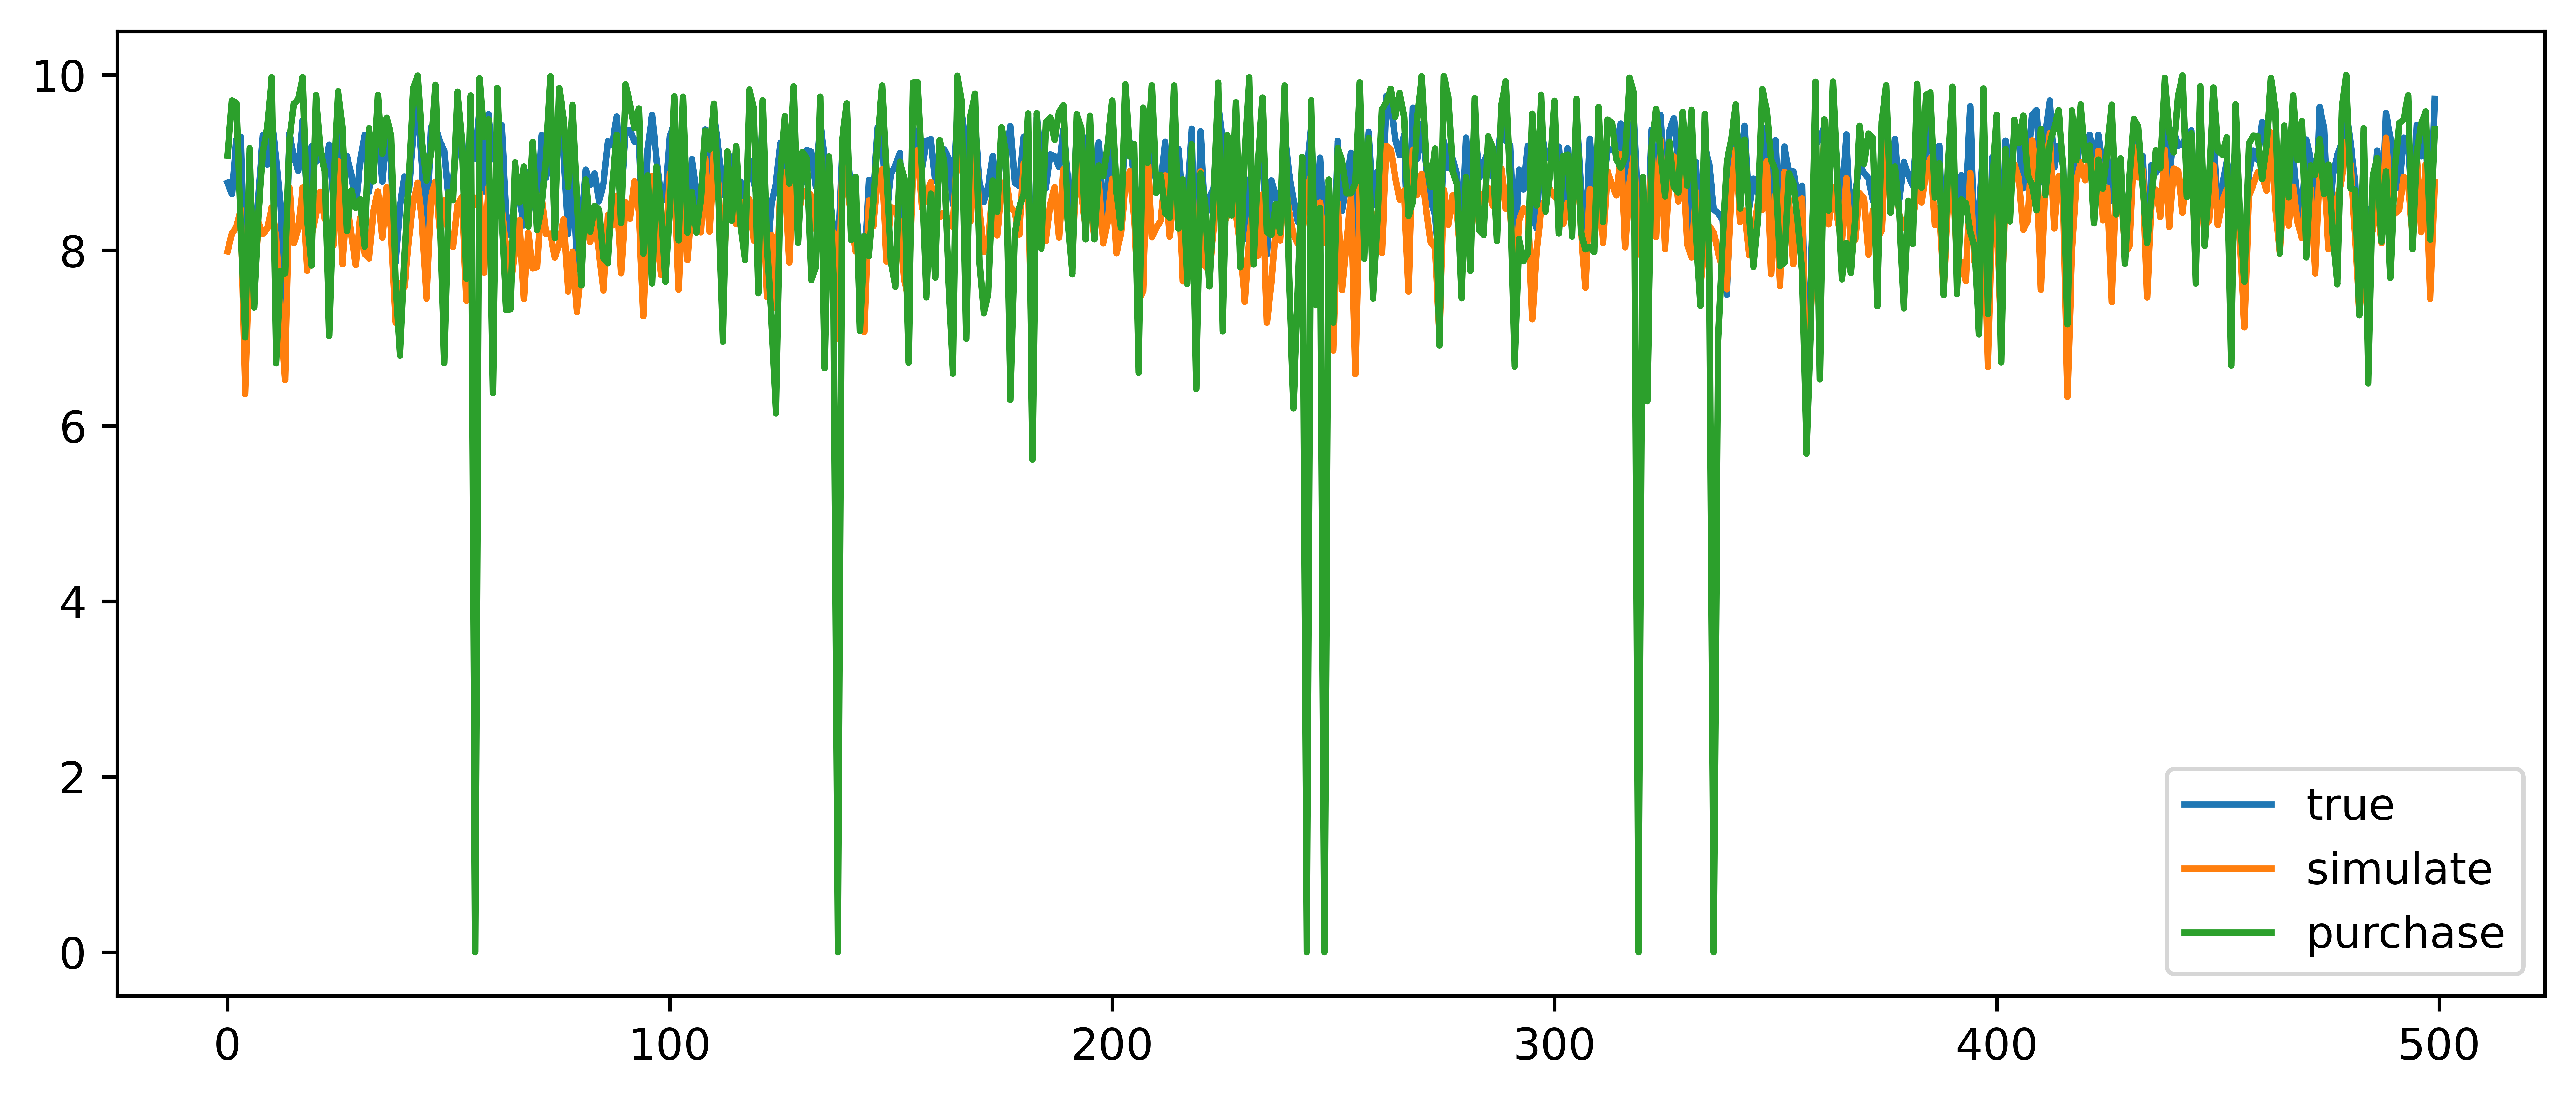

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4),dpi = 1000)
plt.plot(revenue_list1,label = 'true')
plt.plot(revenue_list2, label = 'simulate')
plt.plot(true_profit_list,label = 'purchase')
plt.legend()

9.729056979933723

In [18]:
print(prob((ass_list[100] @ TRUE_THETA.reshape(10,1)).reshape(1,-1)))
print(prob(calculate_v(torch.tensor(ass_list[100],dtype=torch.float32), LAMBDA, theta_tensor)[0]))

[array([0.24755697, 0.17920725, 0.10858287, 0.22995762, 0.22108807])]
[0.24169918462986675, 0.20333439472951406, 0.09201091568338936, 0.16126957117020252, 0.28380717698587393]


In [19]:
print(prob((ass_list[99] @ TRUE_THETA.reshape(10,1)).reshape(1,-1)))
print(prob(calculate_v(torch.tensor(ass_list[99],dtype=torch.float32), LAMBDA, theta_tensor)[0]))


[array([0.15502461, 0.32562099, 0.22413951, 0.26484381])]
[0.18070383380432709, 0.3385533926216585, 0.23067035750588713, 0.21236329738756585]


In [13]:
purchase_list[99]

array([1, 0, 0, 0])

In [24]:
calculate_v(torch.tensor(ass_list[3],dtype=torch.float32), LAMBDA, theta_tensor)[0]

array([1.93355882, 1.94060946])

In [ ]:
model()

In [43]:
torch.save(model,'testmodel.pth')

In [45]:
np.save('testtheta.npy',theta)

In [ ]:
# regret calculate
# ult - 1  让不购买概率最大
# matolotlib linear  10000 epoch 
# 真实情况下的expected revenue， theta， Truetheta
# expected 和 assortment 的revenue 顾客的purchase 
# 


